In [67]:
#Imports

import copy
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from matplotlib.ticker import FuncFormatter

In [68]:
# Define a function to format the ticks with 2 decimal places
def format_ticks(value, _):
    return f'{value:.3f}'

In [69]:
energy_types = ["Load", "PV", "Prosumpt"]
directory = "results/"
pattern = re.compile(r'\d+')

organized_results = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for energy_type in energy_types:
    for filename in os.listdir(directory):
        
        if energy_type in filename and '_all_' in filename and filename.endswith('.pkl'):
            
            distribution = filename.split('_')[3]
            match = re.match(r"([a-zA-Z]+)(\d+)", distribution)

            if match:
                distribution_part = match.group(1).upper()  # Convert the alphabetic part to uppercase
                noise_part = match.group(2)
            elif 'LL_' in filename:
                distribution_part = "Local"
                noise_part = "0"
            else:
                distribution_part = "noAttack"
                noise_part = "0"

            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                
                organized_results[energy_type][distribution_part][noise_part]["cnn"] = data["cnn_all_results"]
                organized_results[energy_type][distribution_part][noise_part]["bilstm"] = data["bilstm_all_results"]
                organized_results[energy_type][distribution_part][noise_part]["softdense"] = data["softdense_all_results"]
                organized_results[energy_type][distribution_part][noise_part]["softlstm"] = data["softlstm_all_results"]

# Convert the defaultdict back to a regular dictionary (if desired)
organized_results = dict(organized_results)

In [70]:
energy = ["Load", "PV", "Prosumpt"]
data_dist = "UNID" #Local, "noAttack"
model_plot = "softdense"
noise_sc = "1"

for energy in energy:

    print("------", energy, "-------")
    print("Mean: ", organized_results[energy][data_dist][noise_sc][model_plot][organized_results[energy][data_dist][noise_sc][model_plot]["user"]=="user2"]["mae"].mean().round(4))
    print("STD: ", organized_results[energy][data_dist][noise_sc][model_plot][organized_results[energy][data_dist][noise_sc][model_plot]["user"]=="user2"]["mae"].std().round(4))

------ Load -------
Mean:  0.0649
STD:  0.0255
------ PV -------
Mean:  0.0379
STD:  0.0261
------ Prosumpt -------
Mean:  0.0836
STD:  0.0012


# Plotting

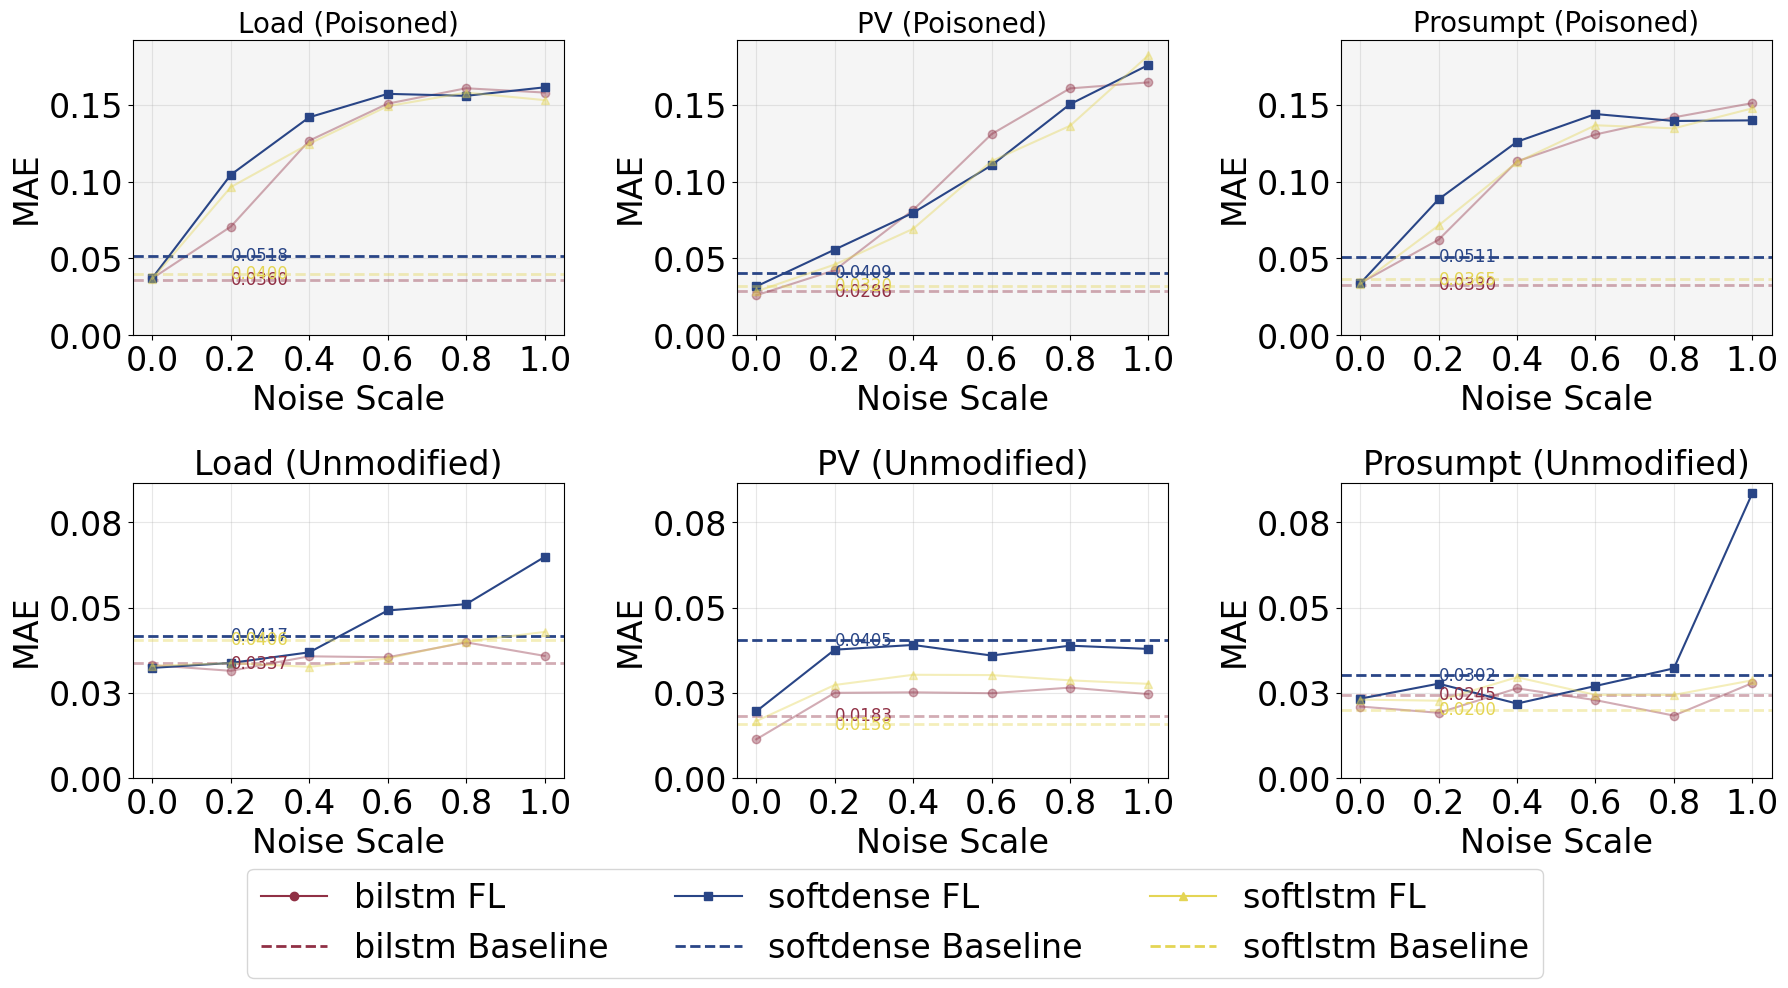

In [93]:
from matplotlib.ticker import FormatStrFormatter

# Define plot parameters
noise_levels = ["0", "02", "04", "06", "08", "1"]
users = ["user1", "user2"]
energy_types = ["Load", "PV", "Prosumpt"]
models = ["bilstm", "softdense", "softlstm"]
global_min_rmse = float('inf')
global_max_rmse = float('-inf')
offset = 0.02
metric = "mae"
energy_type_distribution = {"Load": "UNID", "PV": "UNID", "Prosumpt": "UNID"}

# Calculate the maximum metric value for each user
max_metric_user1 = 0
max_metric_user2 = 0
for user_plot in users:
    for energy_type in energy_types:
        for model in models:
            for noise in noise_levels:
                try:
                    if noise == "0":
                        df = organized_results[energy_type]["noAttack"]["0"][model]
                    else:
                        df = organized_results[energy_type][energy_type_distribution[energy_type]][noise][model]
                    user_df = df[df["user"] == user_plot]
                    local_max = user_df[metric].mean()
                    if user_plot == "user1" and local_max > max_metric_user1:
                        max_metric_user1 = local_max
                    elif user_plot == "user2" and local_max > max_metric_user2:
                        max_metric_user2 = local_max
                except KeyError:
                    continue

# Add an offset to ensure lines are not cut off
y_limit_user1 = max_metric_user1 + 0.01
y_limit_user2 = max_metric_user2 + 0.003


# Create figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Iterate over the users and energy types
for row, user_plot in enumerate(users):
    for col, energy_type in enumerate(energy_types):
        ax = axes[row * 3 + col]
        distribution = energy_type_distribution[energy_type]
        
        handles = []

        for model in models:
            mean_results = {"noise": [], metric: [], "std": []}
            
            # Collect data for each noise level
            for noise in noise_levels:
                try:
                    if noise == "0":
                        df = organized_results[energy_type]["noAttack"]["0"][model]
                    else:
                        df = organized_results[energy_type][distribution][noise][model]
                    user_df = df[df["user"] == user_plot]
                    mean_results["noise"].append(noise)
                    mean_results[metric].append(user_df[metric].mean())
                    mean_results["std"].append(user_df[metric].std())
                except KeyError:
                    continue

            mean_df = pd.DataFrame(mean_results)

            # Define colors and markers for each model
            color, marker = {
                "bilstm": ("#903045", 'o'),
                "softdense": ("#294586", 's'),
                "softlstm": ("#E4D554", '^')
            }[model]
            line, = ax.plot([], [], label=f"{model.lower()} FL", marker=marker, color=color)
            baseline, = ax.plot([], [], linestyle='--', color=color, linewidth=2, label=f"{model.lower()} Baseline")
            handles.extend([line, baseline])

            alpha_value = 0.4 if model in ["bilstm", "softlstm"] else 1.0
            # Plot data with transparency for the specified models
            ax.plot(mean_df["noise"], mean_df[metric], label=f"{model.upper()} {metric}", marker=marker, color=color, alpha=alpha_value)
        
            #for i, (x, y) in enumerate(zip(mean_df["noise"], mean_df[metric])):
            #    ax.text(x, y, f'{y:.4f}', fontsize=12, ha='center')
            
            # Plot benchmark for Local Learning
            try:
                local_df = organized_results[energy_type]["Local"]["0"][model]
                local_user_df = local_df[local_df["user"] == user_plot]
                local_rmse = local_user_df[metric].mean()
                ax.axhline(y=local_rmse, color=color, linestyle='--', linewidth=2, label=f"{model.upper()} Baseline", alpha=alpha_value)
            except KeyError:
                continue

            ax.text(1, local_rmse, f'{local_rmse:.4f}', fontsize=12, ha='left', va='center', color=color)

        # Customize plot
        if user_plot == "user1":
            ax.set_title(f"{energy_type} (Poisoned)", fontsize=20)
            ax.set_ylim(0, y_limit_user1)

            ax.set_facecolor('#F5F5F5')
        else:
            ax.set_title(f"{energy_type} (Unmodified)", fontsize=24)
            ax.set_ylim(0, y_limit_user2)

            #ax.set_facecolor('#FFF4F4')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xlabel("Noise Scale", fontsize=24)
        ax.set_ylabel(metric.upper(), fontsize=24)
        ax.tick_params(axis='both', which='major', labelsize=24)

        ax.set_xticks(noise_levels)
        ax.set_xticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])
        # Set y-axis limits specific to each user row
            
        ax.grid(True, alpha=0.3)

# Adjust layout and add a single legend below all plots
fig.tight_layout(rect=[0, 0.12, 1, 1])  # Reserve space at the bottom for legend
#fig.legend(models, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize=16)
# Add the customized legend below all plots
plt.subplots_adjust(hspace=0.5, wspace=0.4) 
fig.legend(handles=handles, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize=24)
#plt.savefig("figures/PoisonAttack.pdf")
plt.show()


# Backdoor

C:\Users\rs1044\AppData\Local\Temp\ipykernel_776\2483030026.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  organized_results[energy]["noAttack"]["0"][model][(organized_results[energy]["noAttack"]["0"][model]['hour'].isin([0, 1]))][organized_results[energy]["noAttack"]["0"][model]["user"]=="user1"]["mae"]


8      0.004475
11     0.005023
12     0.004950
13     0.004628
62     0.008238
63     0.008609
64     0.008504
65     0.008956
103    0.005454
106    0.006471
109    0.006777
111    0.007956
Name: mae, dtype: float32

In [88]:
energys = ["Load", "PV", "Prosumpt"]
moodals = ["softdense"]

for energy in energys:
    for model in moodals:
        
        print(energy, "----------------------------------------")

        Pois_backdoor =  organized_results[energy]["NORMBACKDOOR"]["1"][model][(organized_results[energy]["NORMBACKDOOR"]["1"][model]['hour'].isin([0, 1]))][organized_results[energy]["NORMBACKDOOR"]["1"][model]["user"]=="user1"]["mae"]
        Pois_nobackdoor = organized_results[energy]["noAttack"]["0"][model][(organized_results[energy]["noAttack"]["0"][model]['hour'].isin([0, 1]))][organized_results[energy]["noAttack"]["0"][model]["user"]=="user1"]["mae"]
        
        print("Pois Backdoor - MAE: ", Pois_backdoor.mean().round(4), "STD: ", Pois_backdoor.std().round(4))
        print("Pois noBack - MAE: ", Pois_nobackdoor.mean().round(4), "STD: ", Pois_nobackdoor.std().round(4))
        
        print("Diff: Mean ", Pois_backdoor.mean().round(4) - Pois_nobackdoor.mean().round(4), "STD: ", Pois_backdoor.std().round(4) - Pois_nobackdoor.std().round(4))
        
        print()

        Un_backdoor =  organized_results[energy]["NORMBACKDOOR"]["1"][model][(organized_results[energy]["NORMBACKDOOR"]["1"][model]['hour'].isin([0, 1]))][organized_results[energy]["NORMBACKDOOR"]["1"][model]["user"]=="user2"]["mae"]
        Un_nobackdoor = organized_results[energy]["noAttack"]["0"][model][(organized_results[energy]["noAttack"]["0"][model]['hour'].isin([0, 1]))][organized_results[energy]["noAttack"]["0"][model]["user"]=="user2"]["mae"]
        
        print("Un Backdoor - Mean: ", Un_backdoor.mean().round(4), "STD: ", Un_backdoor.std().round(4))
        print("Un nobackdoor - Mean: ", Un_nobackdoor.mean().round(4), "STD: ", Un_nobackdoor.std().round(4))
        
        print("Diff: Mean ", Un_backdoor.mean().round(4) - Un_nobackdoor.mean().round(4), "STD: ", Un_backdoor.std().round(4) - Un_nobackdoor.std().round(4))
        

Load ----------------------------------------
Pois Backdoor - MAE:  0.0351 STD:  0.0167
Pois noBack - MAE:  0.0209 STD:  0.011
Diff: Mean  0.014200002 STD:  0.0056999996

Un Backdoor - Mean:  0.0312 STD:  0.0073
Un nobackdoor - Mean:  0.0229 STD:  0.0063
Diff: Mean  0.008299999 STD:  0.0010000002
PV ----------------------------------------
Pois Backdoor - MAE:  0.0089 STD:  0.0064
Pois noBack - MAE:  0.0067 STD:  0.0017
Diff: Mean  0.0022 STD:  0.0047

Un Backdoor - Mean:  0.0054 STD:  0.0023
Un nobackdoor - Mean:  0.0105 STD:  0.006
Diff: Mean  -0.0050999997 STD:  -0.0037
Prosumpt ----------------------------------------
Pois Backdoor - MAE:  0.0765 STD:  0.0164
Pois noBack - MAE:  0.0205 STD:  0.0105
Diff: Mean  0.055999998 STD:  0.0059

Un Backdoor - Mean:  0.0127 STD:  0.0039
Un nobackdoor - Mean:  0.0126 STD:  0.0025
Diff: Mean  9.999983e-05 STD:  0.0014


C:\Users\rs1044\AppData\Local\Temp\ipykernel_776\606923526.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Pois_backdoor =  organized_results[energy]["NORMBACKDOOR"]["1"][model][(organized_results[energy]["NORMBACKDOOR"]["1"][model]['hour'].isin([0, 1]))][organized_results[energy]["NORMBACKDOOR"]["1"][model]["user"]=="user1"]["mae"]
C:\Users\rs1044\AppData\Local\Temp\ipykernel_776\606923526.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Pois_nobackdoor = organized_results[energy]["noAttack"]["0"][model][(organized_results[energy]["noAttack"]["0"][model]['hour'].isin([0, 1]))][organized_results[energy]["noAttack"]["0"][model]["user"]=="user1"]["mae"]
C:\Users\rs1044\AppData\Local\Temp\ipykernel_776\606923526.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Un_backdoor =  organized_results[energy]["NORMBACKDOOR"]["1"][model][(organized_results[energy]["NORMBACKDOOR"]["1"][model][

In [48]:
energy = ["Load", "PV", "Prosumpt"]
data_dist = "NORMBACKDOOR" #Local, "noAttack"
model_plot = "softdense"
noise_sc = "1"

for energy in energy:

    print("------", energy, "-------")
    print("Mean: ", organized_results[energy][data_dist][noise_sc][model_plot][organized_results[energy][data_dist][noise_sc][model_plot]["user"]=="user2"]["mae"].mean().round(4))
    print("STD: ", organized_results[energy][data_dist][noise_sc][model_plot][organized_results[energy][data_dist][noise_sc][model_plot]["user"]=="user2"]["mae"].std().round(4))

------ Load -------
Mean:  0.0392
STD:  0.0179
------ PV -------
Mean:  0.0176
STD:  0.0201
------ Prosumpt -------
Mean:  0.0256
STD:  0.0165


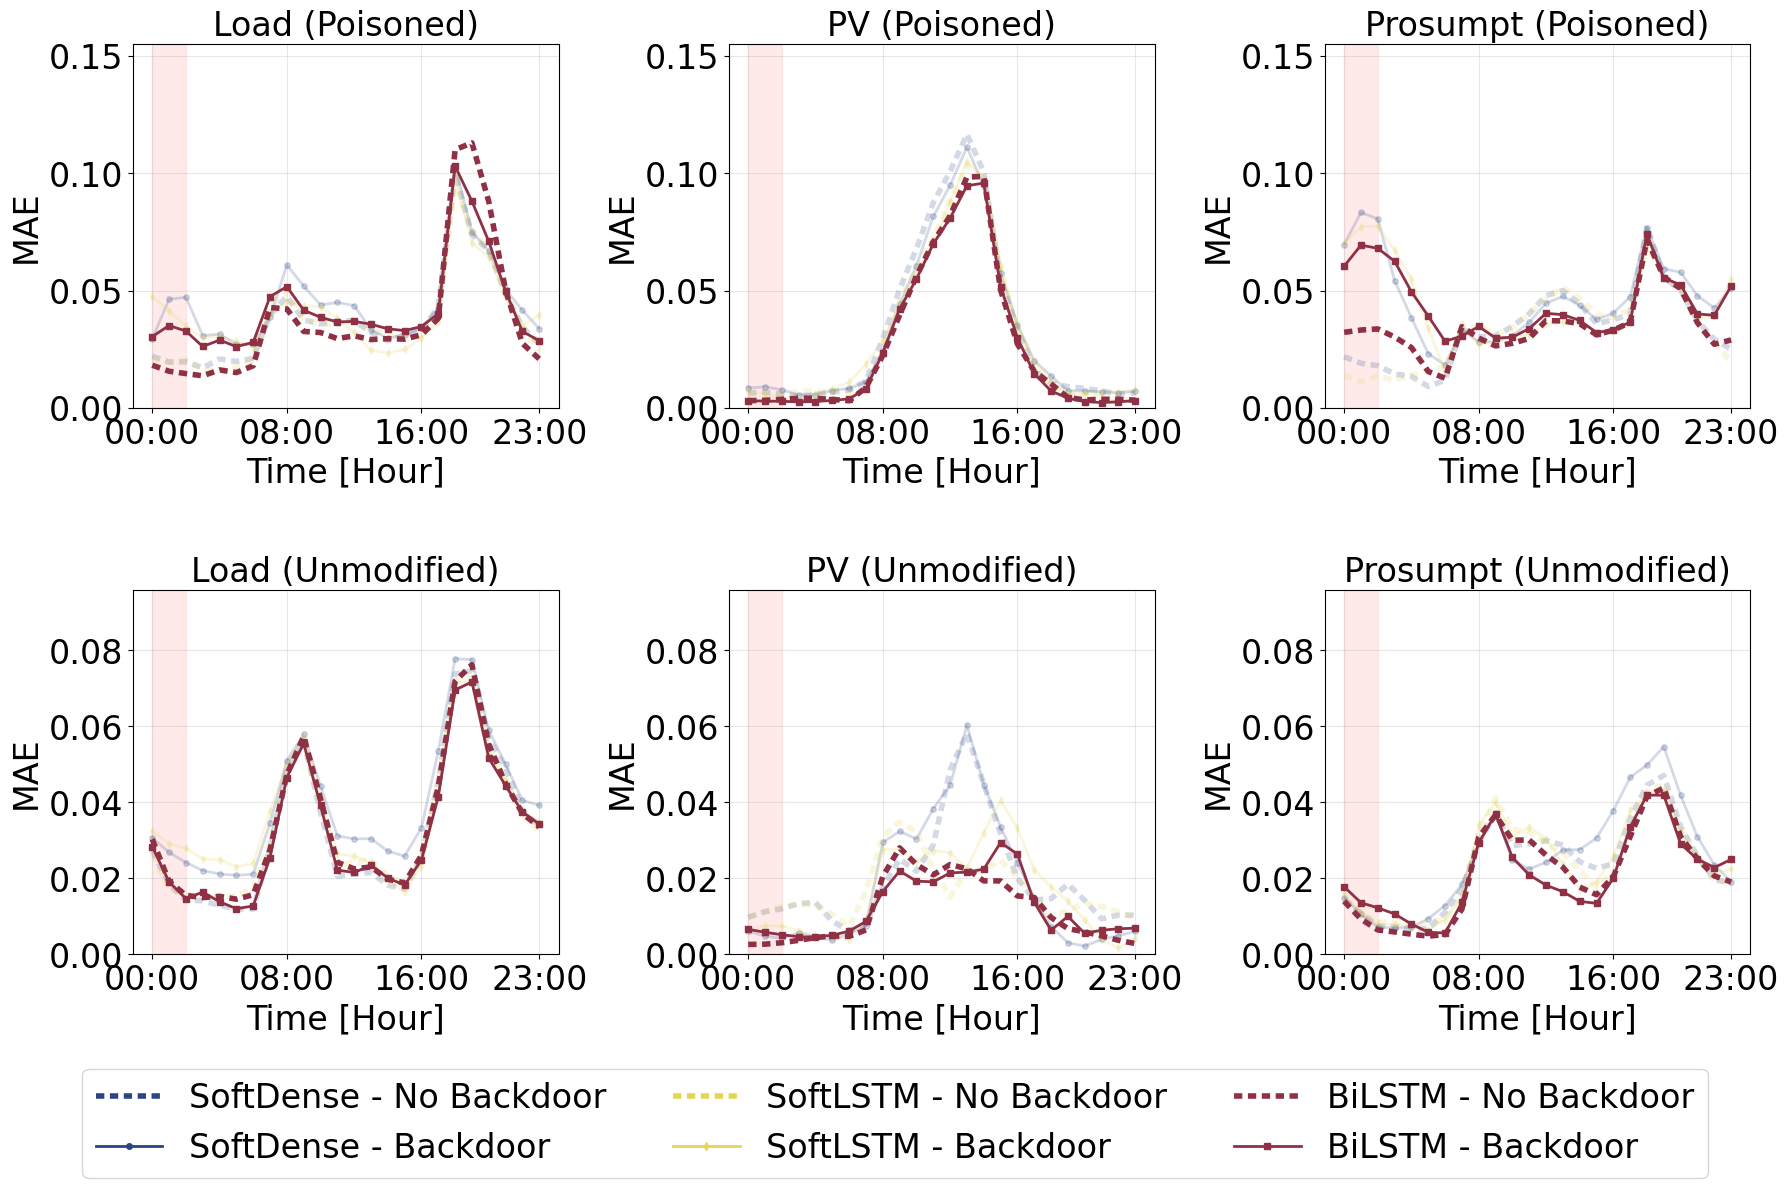

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy

# Configuration
highlight_model = "bilstm"  # Set the model to highlight; change as needed

noise_levels = ["0", "02", "04", "06", "08", "1"]
users = ["user1", "user2"]
energy_types = ["Load", "PV", "Prosumpt"]
models = ["bilstm", "softdense", "softlstm"]

highlight_color = "#ffcccc"  # Very light red

# Define model labels, colors, markers, and line styles
model_labels = {"bilstm": "BiLSTM", "softlstm": "SoftLSTM", "softdense": "SoftDense"}
model_colors = {"bilstm": "#903045", "softdense": "#294586", "softlstm": "#E4D554"}
model_markers = {"bilstm": "s", "softlstm": "d", "softdense": "o"}
line_styles = {"No Backdoor": (0, (1.5, 1)), "Backdoor": "-"}

metric = "mae"

# Calculate the maximum metric value for each user
max_metric_user1 = 0
max_metric_user2 = 0
for user_plot in users:
    for energy_type in energy_types:
        for model in models:
            for noise in noise_levels:
                try:
                    if noise == "0":
                        df = organized_results[energy_type]["noAttack"]["0"][model]
                    else:
                        df = organized_results[energy_type]["NORMBACKDOOR"][noise][model]
                    user_df = df[df["user"] == user_plot]
                    local_max = user_df[metric].max()
                    if user_plot == "user1" and local_max > max_metric_user1:
                        max_metric_user1 = local_max
                    elif user_plot == "user2" and local_max > max_metric_user2:
                        max_metric_user2 = local_max
                except KeyError:
                    continue

# Add an offset to ensure lines are not cut off
y_limit_user1 = max_metric_user1 + 0.01
y_limit_user2 = max_metric_user2 + 0.003

# Create a grid of subplots (2 rows for users, 3 columns for energy types)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  # Flatten for easier indexing

legend_handles = []
legend_labels = []

# Iterate over the users (rows) and energy types (columns)
for row, user in enumerate(users):
    for col, energy in enumerate(energy_types):
        ax = axes[row * 3 + col]  # Select the correct subplot

        # Highlight attacked hours
        ax.axvspan(0, 2, color=highlight_color, alpha=0.4)

        # List of files specific to the energy type
        files = [
            f"FL_{energy}_noBACKDOOR_noBackdoorNoise_all_results.pkl", 
            f"FL_{energy}_BACKDOOR_NormBackdoor1_all_results.pkl"
        ]

        file_labels = {
            f"FL_{energy}_noBACKDOOR_noBackdoorNoise_all_results.pkl": "No Backdoor",
            f"FL_{energy}_BACKDOOR_NormBackdoor1_all_results.pkl": "Backdoor"
        }

        # Plot the non-highlighted models first with transparency
        for selected_model in models:
            if selected_model == highlight_model:
                continue  # Skip the highlighted model for now

            for file in files:
                with open(f"results/{file}", 'rb') as f:
                    all_results = pickle.load(f)

                # Filter the results for the current user
                df = copy.deepcopy(all_results[f"{selected_model}_all_results"][all_results[f"{selected_model}_all_results"]["user"] == user])

                # Create the time column and convert to datetime, keeping only the hour component
                df['time'] = pd.to_datetime(df['hour'], format='%H')

                # Calculate the average RMSE and standard deviation per time
                grouped = df.groupby('time')[metric].agg(["mean", 'std']).reset_index()
                grouped = grouped.sort_values('time').dropna(subset=["mean"])

                # Plot with transparency
                ax.plot(
                    grouped['time'].dt.strftime('%H:%M'), 
                    grouped["mean"], 
                    linestyle=line_styles[file_labels[file]],
                    linewidth=4 if file_labels[file] == "No Backdoor" else 2, 
                    color=model_colors[selected_model], 
                    marker=model_markers[selected_model] if file_labels[file] == "Backdoor" else None, markersize=4,
                    alpha=0.2  # Transparency for non-highlighted models
                )

                # Add to legend handles and labels if not already present
                legend_label = f"{model_labels[selected_model]} - {file_labels[file]}"
                if legend_label not in legend_labels:
                    legend_handle, = ax.plot(
                        [], [],  # Empty plot to create non-transparent legend handle
                        linestyle=line_styles[file_labels[file]],
                        linewidth=4 if file_labels[file] == "No Backdoor" else 2,
                        color=model_colors[selected_model],
                        marker=model_markers[selected_model] if file_labels[file] == "Backdoor" else None, markersize=4,
                    )
                    legend_handles.append(legend_handle)
                    legend_labels.append(legend_label)

        # Now, plot the highlighted model without transparency
        for file in files:
            with open(f"results/{file}", 'rb') as f:
                all_results = pickle.load(f)

            # Filter the results for the current user
            df = copy.deepcopy(all_results[f"{highlight_model}_all_results"][all_results[f"{highlight_model}_all_results"]["user"] == user])

            # Create the time column and convert to datetime, keeping only the hour component
            df['time'] = pd.to_datetime(df['hour'], format='%H')

            # Calculate the average RMSE and standard deviation per time
            grouped = df.groupby('time')[metric].agg(["mean", 'std']).reset_index()
            grouped = grouped.sort_values('time').dropna(subset=["mean"])

            # Plot without transparency for the highlighted model
            ax.plot(
                grouped['time'].dt.strftime('%H:%M'), 
                grouped["mean"], 
                linestyle=line_styles[file_labels[file]],
                linewidth=4 if file_labels[file] == "No Backdoor" else 2, 
                color=model_colors[highlight_model], 
                marker=model_markers[highlight_model] if file_labels[file] == "Backdoor" else None, markersize=4,
                alpha=1.0  # Full opacity for highlighted model
            )

            # Add non-transparent legend entry if not already present
            legend_label = f"{model_labels[highlight_model]} - {file_labels[file]}"
            if legend_label not in legend_labels:
                legend_handle, = ax.plot(
                    [], [],  # Empty plot to create non-transparent legend handle
                    linestyle=line_styles[file_labels[file]],
                    linewidth=4 if file_labels[file] == "No Backdoor" else 2,
                    color=model_colors[highlight_model],
                    marker=model_markers[highlight_model] if file_labels[file] == "Backdoor" else None, markersize=4,
                )
                legend_handles.append(legend_handle)
                legend_labels.append(legend_label)

        # Customize plot
        if user == "user1":
            ax.set_title(f"{energy} (Poisoned)", fontsize=24)
            ax.set_ylim(0, y_limit_user1)
        else:
            ax.set_title(f"{energy} (Unmodified)", fontsize=24)
            ax.set_ylim(0, y_limit_user2)

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_xlabel("Time [Hour]", fontsize=24)
        ax.set_ylabel("MAE", fontsize=24)
        
        tick_positions = [grouped['time'].dt.strftime('%H:%M').iloc[0], 
                          grouped['time'].dt.strftime('%H:%M').iloc[len(grouped) // 3], 
                          grouped['time'].dt.strftime('%H:%M').iloc[2 * len(grouped) // 3], 
                          grouped['time'].dt.strftime('%H:%M').iloc[-1]]
        ax.set_xticks(tick_positions)
        ax.tick_params(axis='both', which='major', labelsize=24)           
        ax.grid(True, alpha=0.3)

# Adjust layout and add a single legend below all plots using unique handles and labels
fig.tight_layout(rect=[0, 0.12, 1, 1])  
plt.subplots_adjust(hspace=0.5, wspace=0.4) 
fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize=24)
plt.savefig("figures/BackdoorAttack.pdf")
plt.show()
